In [1]:
# Notebook based on https://keisen.github.io/tf-keras-vis-docs/examples/attentions.html#Vanilla-Saliency

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
model = VGG16()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted label: library (76.03%)
top 5:
[[('n03661043', 'library', np.float32(0.7603097)), ('n02788148', 'bannister', np.float32(0.051680993)), ('n04204347', 'shopping_cart', np.float32(0.03483168)), ('n02871525', 'bookshop', np.float32(0.034148265)), ('n04311004', 'steel_arch_bridge', np.float32(0.032014873))]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Predicted label: harp (13.32%)
top 5:
[[('n03495258', 'harp', np.float32(0.13321608)), ('n04258138', 'solar_dish', np.float32(0.09027977)), ('n04296562', 'stage', np.float32(0.08122042)), ('n03452741', 'grand_piano', np.float32(0.04027211)), ('n03201208', 'dining_table', np.float32(0.03635403))]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Predicted label: library (99.78%)
top 5:
[[('n03661043', 'library', np.float32(0.99779177)), ('n04081281', 'restaurant', np.float32(0.001120895)), ('n04501370', 'turnstile', np.float32(0.00043170815)), ('n02871525', 'bookshop', np.float32(0.00023636442)), ('n03899768', 

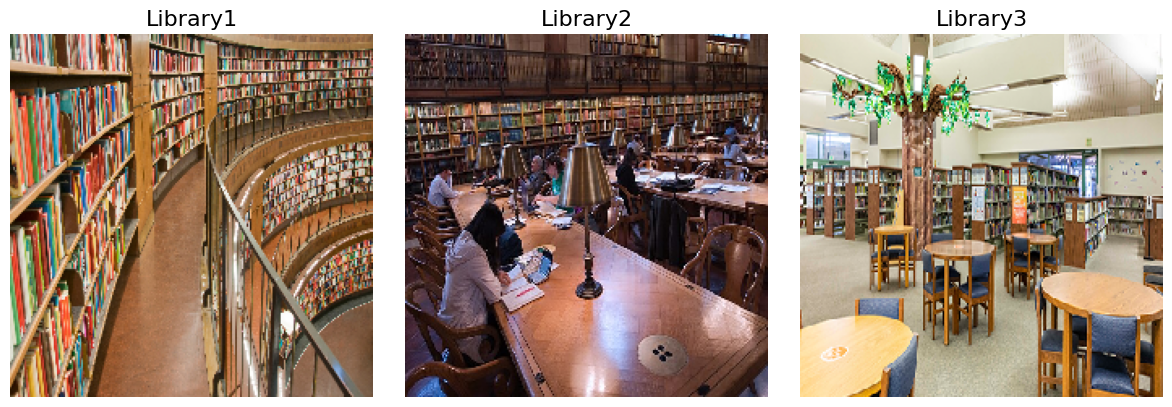

In [3]:
# Image titles
image_titles = ['Library1', 'Library2', 'Library3']

# Load images and Convert them to a Numpy array
img1 = load_img('images/library1.jpeg', target_size=(224, 224))
img2 = load_img('images/library3.jpg', target_size=(224, 224))
img3 = load_img('images/library4.png', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
indices = []
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')

    image = img_to_array(images[0])
    image = images[i].reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    pred = model.predict(image)
    # convert the probabilities to class labels
    labeltopk = decode_predictions(pred)
    # retrieve the most likely result, e.g. highest probability
    label = labeltopk[0][0]
    # print the classification
    print('Predicted label: %s (%.2f%%)' % (label[1], label[2]*100))
    print("top 5:")
    print(labeltopk)
    indices.append (np.argmax(pred))
    
plt.tight_layout()
plt.show()

Implement required functions 
----------------------------------------------

### Model modifier

When the softmax activation function is applied to the last layer of model, it may obstruct generating the attention images, so you should replace the function to a linear activation function. Although we create and use `ReplaceToLinear` instance here, we can also use the model modifier function defined by ourselves.

In [4]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

### Score function

And then, you **MUST** create `Score` instance or define `score function` that returns target scores. Here, they return the score values corresponding Goldfish, Bear, Assault Rifle.

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score = CategoricalScore(indices)# 294, 413])

# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
def score_function(output):
    # The `output` variable refers to the output of the model,
    # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
    return (output[0][1], output[1][294], output[2][413])

## Vanilla Saliency

`Saliency` generates a saliency map that appears the regions of ​​the input image that contributes the most to the output value.

/Users/marcos.bueno/PycharmProjects/posthoc/.venv/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(3, 224, 224, 3))']
  warnings.warn(msg)


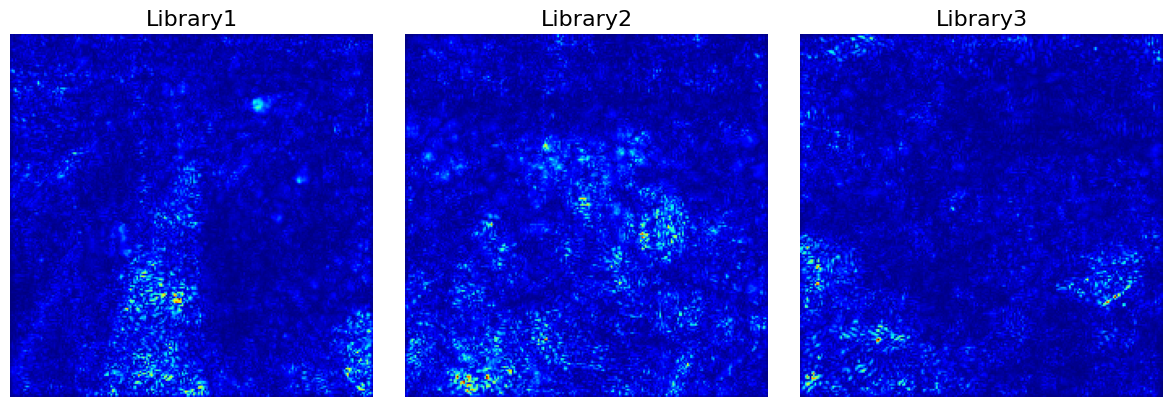

CPU times: user 5.9 s, sys: 892 ms, total: 6.79 s
Wall time: 1.66 s


In [6]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
# from tf_keras_vis.utils import normalize

# Create Saliency object.
saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

# Generate saliency map
saliency_map = saliency(score, X)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# saliency_map = normalize(saliency_map)

# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## GradCAM

Saliency is one of useful way of visualizing attention that appears the regions of the input image that contributes the most to the output value.
GradCAM is another way of visualizing attention over input. Instead of using gradients of model outputs, it uses of penultimate layer output (that is the convolutional layer just before Dense layers).

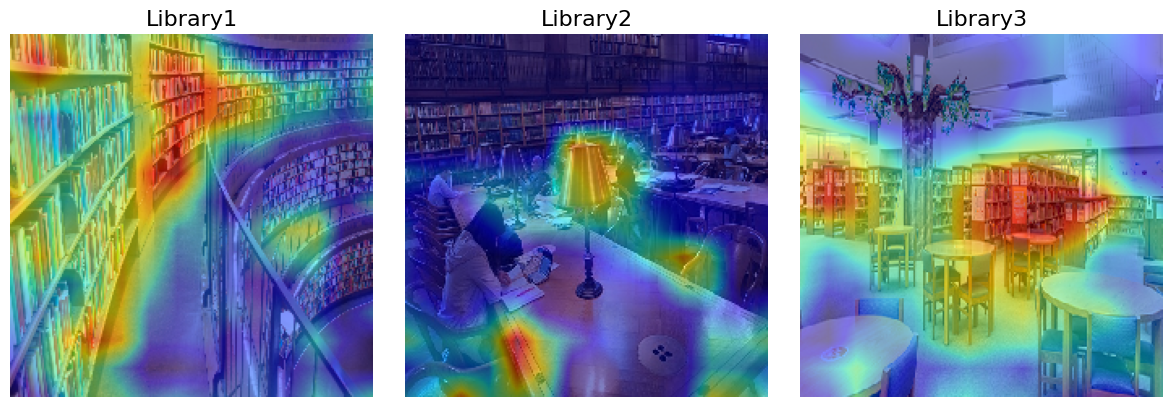

CPU times: user 5.85 s, sys: 959 ms, total: 6.81 s
Wall time: 1.72 s


In [7]:
%%time

from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

# Create Gradcam object
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

## Since v0.6.0, calling `normalize()` is NOT necessary.
# cam = normalize(cam)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5) # overlay
    ax[i].axis('off')
plt.tight_layout()
plt.show()